### Import the parser along side pandas

In [1]:
import pandas as pd
from Parser import parse_sugar_se

### Defining the parsed csv file to the variable result
> The default for the parser is set to Sugar SE.csv in the data file

In [10]:
result = parse_sugar_se() 

### Sorting the tables contained within the CSV to their own variables

In [9]:
free = result.free_energy
dse  = result.dispersive_surface_energy
inj  = result.injection_items

In [15]:
free.columns

Index(['n/nm', 'Solvent Name', 'Unit', 'En. (Stz Max)', 'En. (Stz Com)',
       'En. (Pol Max)', 'En. (Pol Com)', 'Interpolated Retention Volume (Max)',
       'Interpolated Retention Volume (Com)', 'Column Temperature [Kelvin]'],
      dtype='object')

### For Acid-Base component further data processing is required, tidying up these bigger tables into smaller sections required for these calculations

In [31]:
free_yab = free[[
    'n/nm', 'Solvent Name', 'En. (Pol Com)',
]]

ethyl_acetate = free_yab.query("`Solvent Name` == 'ETHYL ACETATE'").copy()
dichloromethane = free_yab.query("`Solvent Name` == 'DICHLOROMETHANE'").copy()

ethyl_acetate.head(6), dichloromethane.head(6)

(     n/nm   Solvent Name  En. (Pol Com)
 13  0.005  ETHYL ACETATE      11.676718
 22  0.010  ETHYL ACETATE      11.423893
 31  0.025  ETHYL ACETATE      10.776600
 40  0.050  ETHYL ACETATE      10.119492
 49  0.100  ETHYL ACETATE       9.305017
 58  0.140  ETHYL ACETATE       9.212943,
      n/nm     Solvent Name  En. (Pol Com)
 14  0.005  DICHLOROMETHANE       7.956350
 23  0.010  DICHLOROMETHANE       7.891442
 32  0.025  DICHLOROMETHANE       7.519317
 41  0.050  DICHLOROMETHANE       7.227040
 50  0.100  DICHLOROMETHANE       7.057762
 59  0.140  DICHLOROMETHANE       7.110553)

### This gives us the polar (acid-base) component across all surface coverages (n/nm) for this methodology and shows the Polarisation and peak COM parameter which we will use the Della Volpe equation with to solve for Acid-Base component.

In [32]:
def calculate_acid_base():
    """
    Calculate the acid-base component using Della Volpe method.
    Convert En. (Pol COM) from kJ/mol to J/mol and apply the formula:
    deltaG_ab = En. (Pol COM) J/mol / Na (6.022e23) * A_probe
    ys+ = (deltaG_ab / -2)^2 / LP_ea
    ys- = (deltaG_ab / -2)^2 / LP_dcm

    yab = 2*(sqrt(ys+*ys-))
    """
    #A_probe is probe area used by SMS in nm²
    #LP_probe is probe liquid parameters used by SMS in J/m²
    A_ea, LP_ea = (3.3e-19, 0.47567)
    A_dcm, LP_dcm = (2.45e-19, 0.12458)

    Na = 6.022e23  # Avogadro's number
    def compute_yab(row, A_probe, LP_probe):
        deltaG_ab = (row['En. (Pol Com)'] * 1000) / Na * A_probe  # Convert kJ/mol to J/mol
        ys = (deltaG_ab / -2) ** 2 / LP_probe
        return ys
    dichloromethane['ys+'] = dichloromethane.apply(compute_yab, axis=1, A_probe=A_dcm, LP_probe=LP_dcm)
    ethyl_acetate['ys-'] = ethyl_acetate.apply(compute_yab, axis=1, A_probe=A_ea, LP_probe=LP_ea)
    yab = 2 * (dichloromethane['ys+'] * ethyl_acetate['ys-']).pow(0.5)
    return yab
yab = calculate_acid_base()
yab.head()



13   NaN
14   NaN
22   NaN
23   NaN
31   NaN
dtype: float64

In [35]:
import numpy as np
import pandas as pd

def calculate_yab_from_two_probes(ethyl_acetate: pd.DataFrame, dichloromethane: pd.DataFrame) -> pd.DataFrame:
    # constants for ethyl acetate and dichloromethane
    # probe area (A_probe) in nm² and liquid parameters (LP_probe) in J/m²
    # values taken or manually calculated from SMS software
    A_ea, LP_ea = (3.3e-19, 0.47567)
    A_dcm, LP_dcm = (2.45e-19, 0.12458)
    Na = 6.022e23

    ea = ethyl_acetate[["n/nm", "En. (Pol Com)"]].rename(columns={"En. (Pol Com)": "pol_ea"}).copy()
    dcm = dichloromethane[["n/nm", "En. (Pol Com)"]].rename(columns={"En. (Pol Com)": "pol_dcm"}).copy()

    merged = ea.merge(dcm, on="n/nm", how="inner").sort_values("n/nm")

    # ys- from ethyl acetate
    deltaG_ea = (merged["pol_ea"] * 1000) / (Na * A_ea)
    ys_minus = (((deltaG_ea / -2) ** 2) / LP_ea) * 1000

    # ys+ from dichloromethane
    deltaG_dcm = (merged["pol_dcm"] * 1000) / (Na * A_dcm)
    ys_plus = (((deltaG_dcm / -2) ** 2) / LP_dcm) * 1000

    merged["ys-"] = ys_minus
    merged["ys+"] = ys_plus
    merged["yab"] = 2 * np.sqrt(merged["ys+"] * merged["ys-"])
    return merged[["n/nm", "yab", "ys+", "ys-"]]

yab_df = calculate_yab_from_two_probes(ethyl_acetate, dichloromethane)
yab_df

,n/nm,yab,ys+,ys-
0,0.005,6.508278,5.835871,1.814540
1,0.010,6.315415,5.741042,1.736813
2,0.025,5.676643,5.212365,1.545569
3,0.050,5.123309,4.815029,1.362832
4,0.100,4.600612,4.592108,1.152283
5,0.140,4.589160,4.661061,1.129592


In [40]:
dse_yd = dse[[
    'n/nm', 'Disp. Surf. En. (mJ/m^2) - DnG & Com',
]].rename(columns={'Disp. Surf. En. (mJ/m^2) - DnG & Com': "yd"}).copy()


dse_yd.head(6)

,n/nm,yd
67,0.005,45.969040
68,0.010,44.756973
69,0.025,43.263668
70,0.050,42.287848
71,0.100,40.651364
72,0.140,40.508424


In [41]:
# Keep only the columns we need and merge on n/nm
yd_tbl = dse_yd[["n/nm", "yd"]].copy()
yab_tbl = yab_df[["n/nm", "yab"]].copy()

yt_tbl = (
    yd_tbl
    .merge(yab_tbl, on="n/nm", how="inner")
    .sort_values("n/nm")
    .reset_index(drop=True)
)

yt_tbl["yt"] = yt_tbl["yd"] + yt_tbl["yab"]
yt_tbl

,n/nm,yd,yab,yt
0,0.005,45.969040,6.508278,52.477318
1,0.010,44.756973,6.315415,51.072389
2,0.025,43.263668,5.676643,48.940312
3,0.050,42.287848,5.123309,47.411157
4,0.100,40.651364,4.600612,45.251977
5,0.140,40.508424,4.589160,45.097584


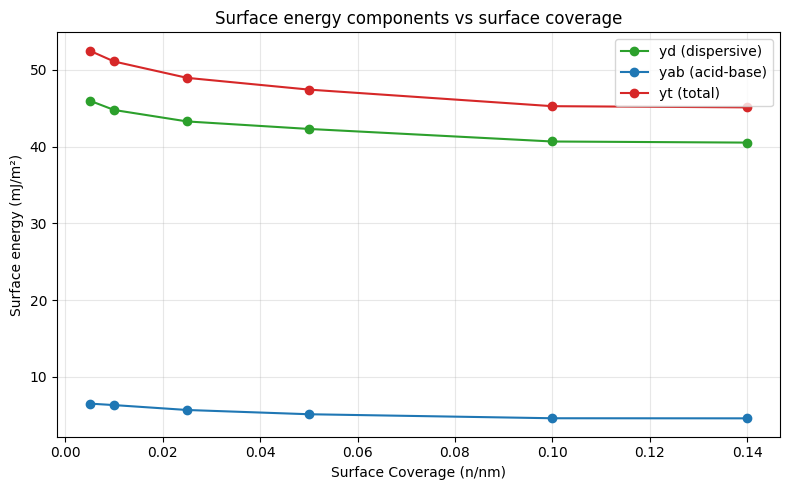

In [48]:
# filepath: Inverse Gas Chromatography/Experimenting.ipynb (cell)
import matplotlib.pyplot as plt

x = yt_tbl["n/nm"]

plt.figure(figsize=(8, 5))
plt.plot(x, yt_tbl["yd"], marker="o", color="tab:green", label="yd (dispersive)")
plt.plot(x, yt_tbl["yab"], marker="o", color="tab:blue", label="yab (acid-base)")
plt.plot(x, yt_tbl["yt"], marker="o", color="tab:red", label="yt (total)")

plt.xlabel("Surface Coverage (n/nm)")
plt.ylabel("Surface energy (mJ/m²)")
plt.title("Surface energy components vs surface coverage")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Heres were i got stuck and the following regression fit is over my head, need to go through in detail and reverse engineer how this is working

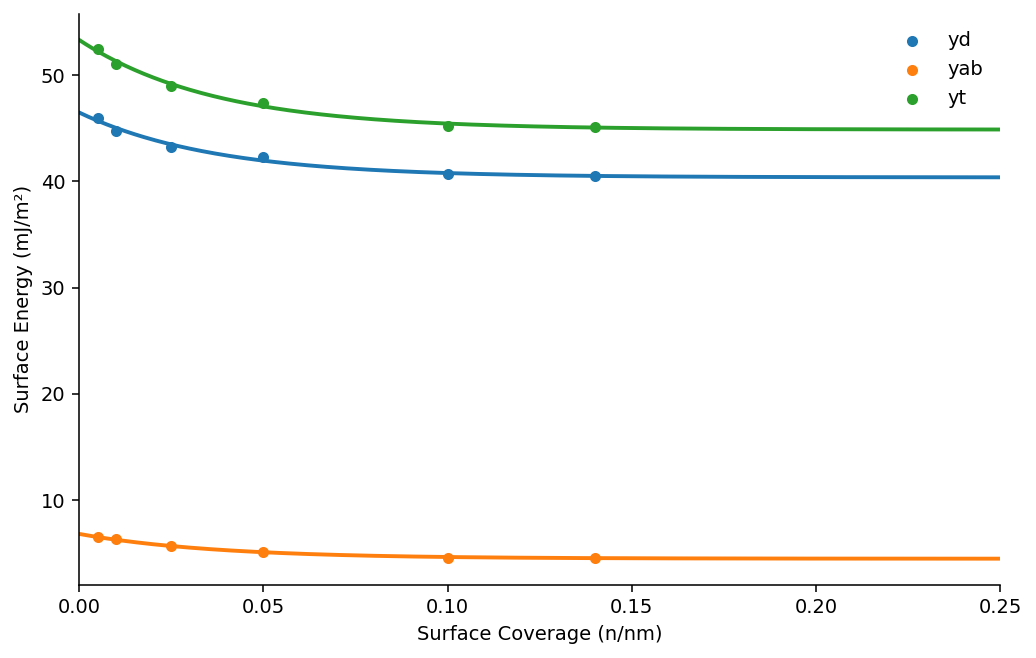

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Exponential-to-asymptote (decay) model
def exp_asym(x, c, a, b):
    return c + a * np.exp(-b * x)

def fit_curve(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    x, y = x[m], y[m]

    # reasonable starting guesses
    c0 = float(np.min(y))
    a0 = float(np.max(y) - np.min(y))
    b0 = 10.0
    popt, _ = curve_fit(exp_asym, x, y, p0=[c0, a0, b0], maxfev=20000)
    return popt

# --- assumes yt_tbl columns: "n/nm", "yd", "yab", "yt" ---
x = yt_tbl["n/nm"].to_numpy(float)

# Fit params
p_yd  = fit_curve(x, yt_tbl["yd"])
p_yab = fit_curve(x, yt_tbl["yab"])
p_yt  = fit_curve(x, yt_tbl["yt"])

# Extend curve to the right (like your example)
x_max_data = float(np.max(x))
x_ext = np.linspace(0.0, max(0.25, x_max_data * 1.25), 400)

# Plot (clean, not “PowerPoint-esque”)
plt.style.use("default")
fig, ax = plt.subplots(figsize=(7.5, 4.8), dpi=140)

ax.scatter(x, yt_tbl["yd"],  s=22, color="tab:blue",   label="yd")
ax.scatter(x, yt_tbl["yab"], s=22, color="tab:orange", label="yab")
ax.scatter(x, yt_tbl["yt"],  s=22, color="tab:green",  label="yt")

ax.plot(x_ext, exp_asym(x_ext, *p_yd),  color="tab:blue",   lw=2)
ax.plot(x_ext, exp_asym(x_ext, *p_yab), color="tab:orange", lw=2)
ax.plot(x_ext, exp_asym(x_ext, *p_yt),  color="tab:green",  lw=2)

ax.set_xlim(0, x_ext.max())
ax.set_xlabel("Surface Coverage (n/nm)")
ax.set_ylabel("Surface Energy (mJ/m²)")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(False)
ax.legend(frameon=False)

plt.tight_layout()
plt.show()